## Libraries

In [2]:
# Import libraries
import netCDF4 as nc
import xarray as xr
import pygrib
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import matplotlib.patheffects as path_effects
import numpy as np
import cartopy.util as cutil
import xarray as xr
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import sys
import warnings
import cdsapi
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units
import re
import matplotlib.colors as mcolors

if not sys.warnoptions:
    warnings.simplefilter("ignore")
import metpy.plots as mpplots
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
import matplotlib.gridspec as gridspec

In [3]:

class GPSConverter(object):
    '''
    GPS Converter class which is able to perform convertions between the 
    CH1903 and WGS84 system.
    '''
    # Convert CH y/x/h to WGS height
    def CHtoWGSheight(self, y, x, h):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        h = (h + 49.55) - (12.60 * y_aux) - (22.64 * x_aux)
        return h

    # Convert CH y/x to WGS lat
    def CHtoWGSlat(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lat = (16.9023892 + (3.238272 * x_aux)) + \
                - (0.270978 * pow(y_aux, 2)) + \
                - (0.002528 * pow(x_aux, 2)) + \
                - (0.0447 * pow(y_aux, 2) * x_aux) + \
                - (0.0140 * pow(x_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lat = (lat * 100) / 36
        return lat

    # Convert CH y/x to WGS long
    def CHtoWGSlng(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lng = (2.6779094 + (4.728982 * y_aux) + \
                + (0.791484 * y_aux * x_aux) + \
                + (0.1306 * y_aux * pow(x_aux, 2))) + \
                - (0.0436 * pow(y_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lng = (lng * 100) / 36
        return lng

    # Convert decimal angle (° dec) to sexagesimal angle (dd.mmss,ss)
    def DecToSexAngle(self, dec):
        degree = int(math.floor(dec))
        minute = int(math.floor((dec - degree) * 60))
        second = (((dec - degree) * 60) - minute) * 60
        return degree + (float(minute) / 100) + (second / 10000)
		
    # Convert sexagesimal angle (dd.mmss,ss) to seconds
    def SexAngleToSeconds(self, dms):
        degree = 0 
        minute = 0 
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return second + (minute * 60) + (degree * 3600)

    # Convert sexagesimal angle (dd.mmss) to decimal angle (degrees)
    def SexToDecAngle(self, dms):
        degree = 0
        minute = 0
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return degree + (minute / 60) + (second / 3600)
    
    # Convert WGS lat/long (° dec) and height to CH h
    def WGStoCHh(self, lat, lng, h):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        h = (h - 49.55) + (2.73 * lng_aux) + (6.94 * lat_aux)
        return h

    # Convert WGS lat/long (° dec) to CH x
    def WGStoCHx(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        x = ((200147.07 + (308807.95 * lat_aux) + \
            + (3745.25 * pow(lng_aux, 2)) + \
            + (76.63 * pow(lat_aux,2))) + \
            - (194.56 * pow(lng_aux, 2) * lat_aux)) + \
            + (119.79 * pow(lat_aux, 3))
        return x

	# Convert WGS lat/long (° dec) to CH y
    def WGStoCHy(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        y = (600072.37 + (211455.93 * lng_aux)) + \
            - (10938.51 * lng_aux * lat_aux) + \
            - (0.36 * lng_aux * pow(lat_aux, 2)) + \
            - (44.54 * pow(lng_aux, 3))
        return y

    def LV03toWGS84(self, east, north, height):
        '''
        Convert LV03 to WGS84 Return a array of double that contain lat, long,
        and height
        '''
        d = []
        d.append(self.CHtoWGSlat(east, north))
        d.append(self.CHtoWGSlng(east, north))
        d.append(self.CHtoWGSheight(east, north, height))
        return d
        
    def WGS84toLV03(self, latitude, longitude, ellHeight):
        '''
        Convert WGS84 to LV03 Return an array of double that contaign east,
        north, and height
        '''
        d = []
        d.append(self.WGStoCHy(latitude, longitude))
        d.append(self.WGStoCHx(latitude, longitude))
        d.append(self.WGStoCHh(latitude, longitude, ellHeight))
        return d
        
if __name__ == "__main__":
    ''' Example usage for the GPSConverter class.'''

    converter = GPSConverter()

    # Coordinates
    wgs84 = []
    lv03  = [567719, 155077, 1974]
    #567719/ 155077  Altitude: 1974
    # Convert WGS84 to LV03 coordinates
    wgs84 = converter.LV03toWGS84(lv03[0], lv03[1], lv03[2])

    print("WGS84: ")
    print(wgs84)
    print("LV03: ")
    print(lv03)


WGS84: 
[46.54620053012867, 7.017760746224894, 2024.97379732]
LV03: 
[567719, 155077, 1974]


## Download ERA5 data

In [10]:
import cdsapi

dataset = "reanalysis-era5-pressure-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "specific_humidity",
        "temperature"
    ],
    "year": ["2021"],
    "month": ["07"],
    "day": ["11", "12"],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "pressure_level": ["850"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [65, -30, 30, 33]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2024-12-10 10:10:36,177 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-10 10:10:36,178 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-10 10:10:36,178 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-10 10:10:36,179 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

2da3ea041aff489d8359e345a7f3964e.nc:   0%|          | 0.00/5.67M [00:00<?, ?B/s]

'2da3ea041aff489d8359e345a7f3964e.nc'

## Relative humidity, geopotential, wind on 500hPa

In [3]:
file_path = "/scratch/mch/fackerma/orders/case_240823/ERA5_data/syn.nc"
df = xr.open_dataset(file_path)

In [4]:
df=df.assign(t_c=lambda df: df.t - 273.15)
df=df.assign(d_c=lambda df: (237.3 * (np.log(df.r / 100) + (17.27 * df.t_c) / (237.3 + df.t_c))) / \
           (17.27 - (np.log(df.r / 100) + (17.27 * df.t_c) / (237.3 + df.t_c))))
df=df.assign(wind_speed=lambda df: (df.u**2 + df.v**2)**0.5 )
df=df.assign(wind_direction=lambda df: (np.degrees(np.arctan2(-df.u, -df.v)) + 360) % 360)
# Constants
R_d = 287.05  # Specific gas constant for dry air, J/(kg*K)
g = 9.80665   # Gravitational acceleration, m/s^2
P_surface = 1000  # Reference surface pressure in hPa
# Calculate height in meters for each pressure level
df = df.assign(height=lambda df: (R_d * df.t / g) * np.log(P_surface / df.pressure_level))
df=df.assign(z_m=lambda df: (df.z / 9.80665)) #geopotential in m
df=df.assign(q_g=lambda df: (df.q*1000)) # specific humidity 

# r Relative Humidity
# t air temperature
# w Vertical wind
# z Geopotential 
# q specific humidity

# Change longitudes
df.coords['longitude'] = (df.coords['longitude'] + 180) % 360 - 180
df = df.sortby(df.longitude)

# Set custom levels
z500_levels= np.arange(5000,6000,50)
z850_levels= np.arange(1000,2000,25)
r_levels = np.arange(0, 101, 10)

# Convert the DataFrame to an xarray Dataset
#ds = xr.Dataset.from_dataframe(df)

# Save the Dataset as a .nc file
#ds.to_netcdf("/scratch/mch/fackerma/orders/case_150619/ERA5_data/ERA5_VP1.nc")

In [19]:
aim_time = 10 # 3 = 0300 UTC

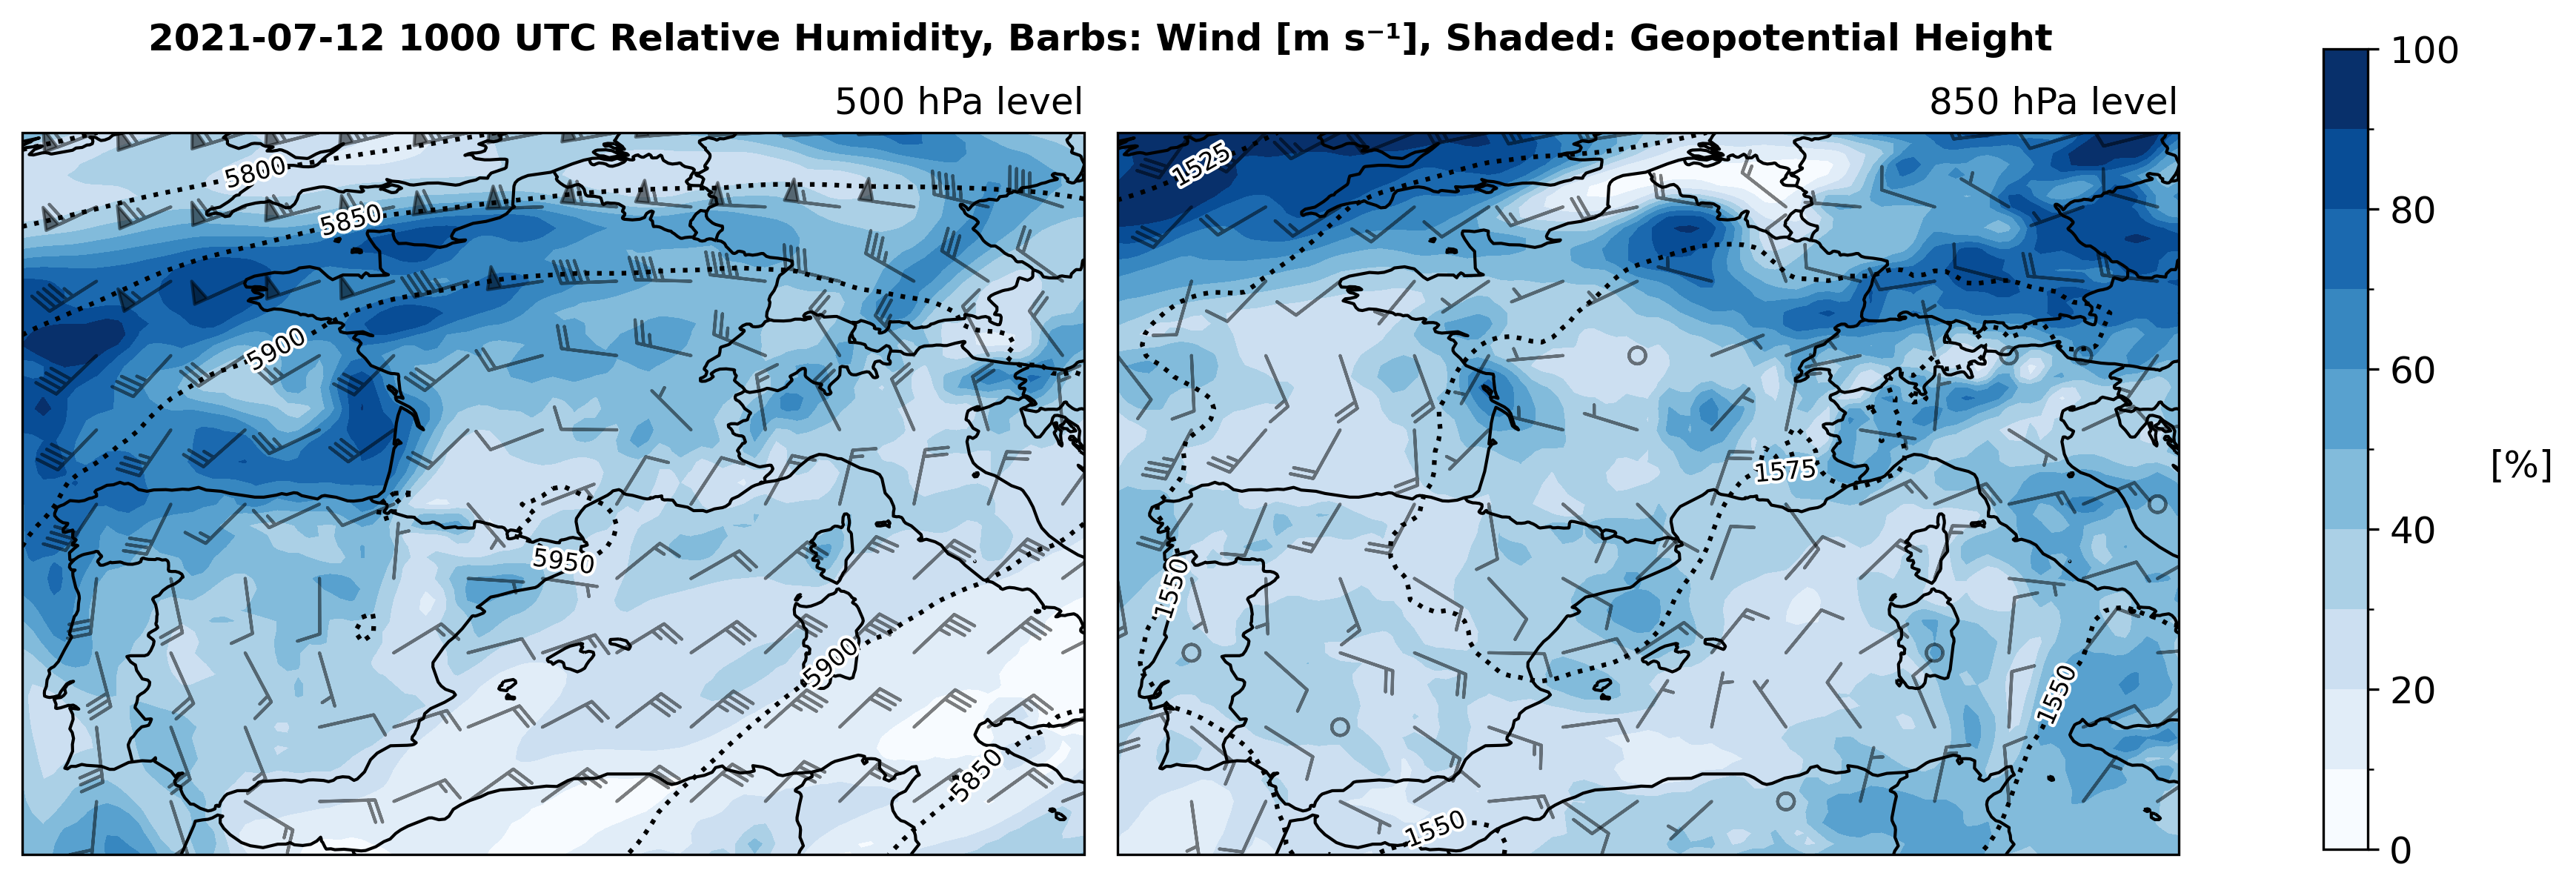

In [ ]:
# Define projection for map plotting
projection = ccrs.PlateCarree()

# Create a 2x1 grid of subplots with PlateCarree projection
fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 4), dpi=300)

# Cap the relative humidity data at 100
df['r'] = df['r'].where(df['r'] <= 100, 100)  # Set values above 100 to 100

# Loop over each subplot to add coastlines or other features
for ax in axes:
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)  # Optional: Add borders
    ax.set_extent([-10, 15, 35, 52], crs=projection)


# Select data for the third valid time (index 2), focusing on Western Europe
data_500 = df.r.sel(longitude=slice(-10, 40), latitude=slice(60, 35), pressure_level=500,valid_time=df.valid_time[aim_time]).squeeze()
data_500.plot.contourf(ax=axes[0], transform=projection, levels=r_levels, add_colorbar=False, cmap='Blues')

data_850 = df.r.sel(longitude=slice(-10, 40), latitude=slice(60, 35), pressure_level=850, valid_time=df.valid_time[aim_time]).squeeze()
p = data_850.plot.contourf(ax=axes[1], transform=projection, levels=r_levels, add_colorbar=False, vmin=0, vmax=100, cmap='Blues')

# Plotting contours with black lines
contour_plot_500 = df.z_m.sel(longitude=slice(-10, 15), latitude=slice(52, 35), valid_time=df.valid_time[aim_time], pressure_level=500).squeeze().plot.contour(ax=axes[0], colors='black', linestyles='dotted', levels=z500_levels)
contour_plot_850 = df.z_m.sel(longitude=slice(-10, 15), latitude=slice(52, 35), valid_time=df.valid_time[aim_time], pressure_level=850).squeeze().plot.contour(ax=axes[1], colors='black', linestyles='dotted', levels=z850_levels)
contour_labels_500 = plt.clabel(contour_plot_500, fontsize=8, fmt='%1.0f', inline=False, inline_spacing=5)         
contour_labels_850 = plt.clabel(contour_plot_850, fontsize=8, fmt='%1.0f', inline=False, inline_spacing=5)

# Apply path effects to contour labels
plt.setp(contour_labels_500, path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
plt.setp(contour_labels_850, path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
# Adjust spacing between the subplots to avoid overlap

subset = df.sel(longitude=slice(-10, 15, 7), latitude=slice(52, 35, 7), valid_time=df.valid_time[aim_time], pressure_level=500)
longitude = subset['longitude'].values
latitude = subset['latitude'].values
u = subset['u'].values
v = subset['v'].values
# Determine the quiver grid
lon, lat = np.meshgrid(longitude, latitude)
# Now use matplotlib's quiver directly
barbs = axes[0].barbs(lon, lat, u, v, barb_increments=dict(half=2, full=4, flag=20), length=6,
                         transform=ccrs.PlateCarree(), alpha=0.5)

subset = df.sel(longitude=slice(-10, 15, 7), latitude=slice(52, 35, 7), valid_time=df.valid_time[aim_time], pressure_level=850)
longitude = subset['longitude'].values
latitude = subset['latitude'].values
u = subset['u'].values
v = subset['v'].values
# Determine the quiver grid
lon, lat = np.meshgrid(longitude, latitude)
# Now use matplotlib's quiver directly
barbs = axes[1].barbs(lon, lat, u, v, barb_increments=dict(half=2, full=4, flag=20), length=6,
                         transform=ccrs.PlateCarree(), alpha=0.5)


# Adjust the position
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.1, wspace=0.1)

# Create a single colorbar
cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9]) 
cbar = plt.colorbar(p, cax=cbar_ax)
cbar.set_label('[%]', labelpad=20, fontsize=12, rotation=360)
cbar.ax.tick_params(labelsize=12)

# Set titles
axes[0].set_title('')
axes[1].set_title('')
axes[0].set_title('500 hPa level', loc='right')
axes[1].set_title('850 hPa level', loc='right')

# Display the figure
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.suptitle('2021-07-12 1000 UTC Relative Humidity, Barbs: Wind [m s⁻¹], Shaded: Geopotential Height' 
             , color='black', fontsize=12, x=0.5, fontweight='bold')

# Save the figure
#plt.savefig("/users/fackerma/newproject1/figures/second_case/" + '210712_1000UTC_RH_wind_geopot_1.png', dpi=300)




## Vertical Profile

In [22]:
file_path = "/scratch/mch/fackerma/orders/case_130721/ERA5_data/vp.nc"
df = xr.open_dataset(file_path)

In [23]:
df=df.assign(t_c=lambda df: df.t - 273.15)
df=df.assign(d_c=lambda df: (237.3 * (np.log(df.r / 100) + (17.27 * df.t_c) / (237.3 + df.t_c))) / \
           (17.27 - (np.log(df.r / 100) + (17.27 * df.t_c) / (237.3 + df.t_c))))
df=df.assign(wind_speed=lambda df: (df.u**2 + df.v**2)**0.5 )
df=df.assign(wind_direction=lambda df: (np.degrees(np.arctan2(-df.u, -df.v)) + 360) % 360)
# Constants
R_d = 287.05  # Specific gas constant for dry air, J/(kg*K)
g = 9.80665   # Gravitational acceleration, m/s^2
P_surface = 1000  # Reference surface pressure in hPa
# Calculate height in meters for each pressure level
df = df.assign(height=lambda df: (R_d * df.t / g) * np.log(P_surface / df.pressure_level))
df=df.assign(z_m=lambda df: (df.z / 9.80665)) #geopotential in m
df=df.assign(q_g=lambda df: (df.q*1000)) # specific humidity 

# Change longitudes
#df.coords['longitude'] = (df.coords['longitude'] + 180) % 360 - 180
#df = df.sortby(df.longitude)


In [30]:
# Select data for St.Gallen (approximate coordinates) and specific time
location = 'Locarno'
latitude, longitude = 46.1700, 8.7996
valid_time = "2021-07-13T06:00:00"
day = '2021-07-13'
hour = '0600'

subset = df.sel(latitude=latitude, longitude=longitude, valid_time=valid_time, method="nearest")

p = subset['pressure_level'].values * units.hPa
z = subset['height'].values * units.m
T = subset['t_c'].values * units.degC
Td = subset['d_c'].values * units.degC
wind_speed = subset['wind_speed'].values * units.meter_per_second
wind_dir = subset['wind_direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)
r = subset['r'].values

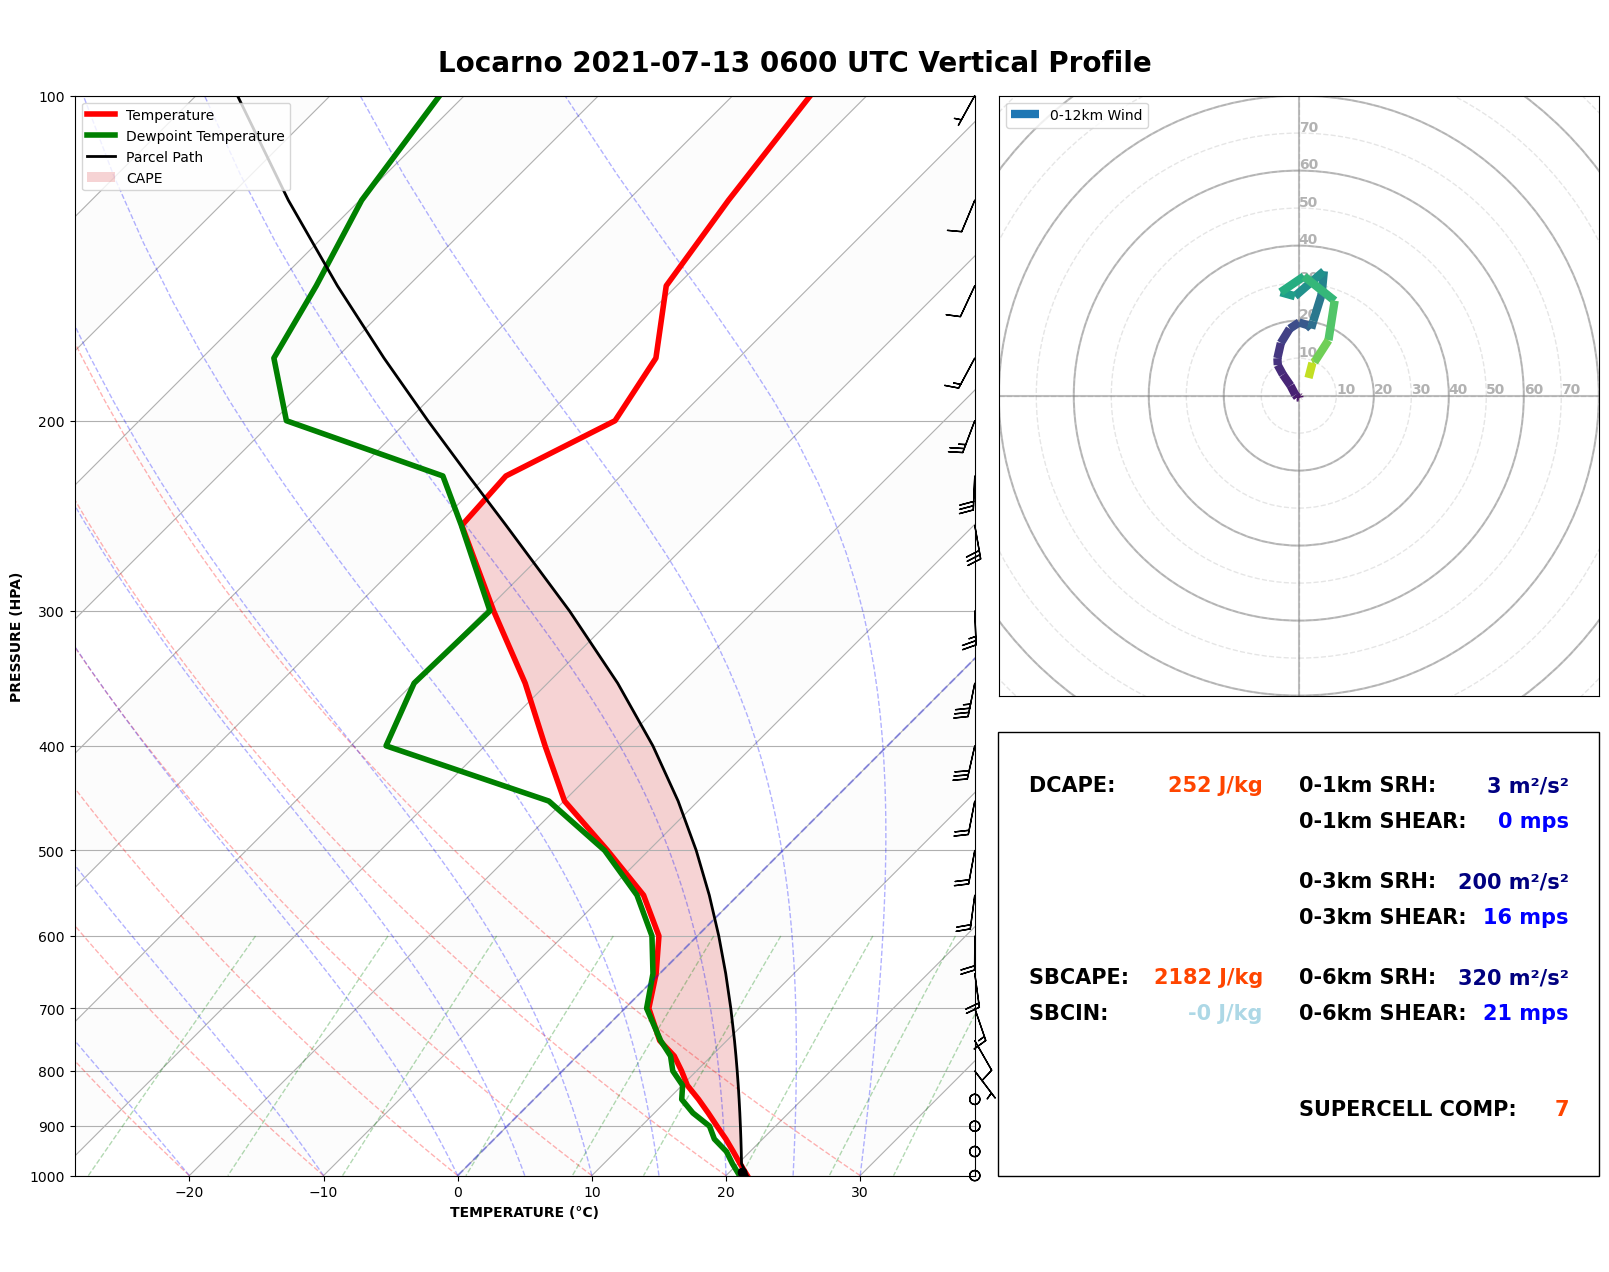

In [ ]:
# STEP 1: CREATE THE SKEW-T OBJECT AND MODIFY IT TO CREATE A
# NICE, CLEAN PLOT
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)

# Set some better labels than the default to increase readability
skew.ax.set_xlabel(str.upper(f'Temperature ({T.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressure ({p.units:~P})'), weight='bold')

# Set the facecolor of the skew-t object and the figure to white
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Here we can use some basic math and Python functionality to make a cool
# shaded isotherm pattern.
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(0, 8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# STEP 2: PLOT DATA ON THE SKEW-T. TAKE A COUPLE EXTRA STEPS TO
# INCREASE READABILITY
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
# Set the linewidth to 4 for increased readability.
# We will also add the 'label' keyword argument for our legend.
skew.plot(p, T, 'r', lw=4, label='Temperature')
skew.plot(p, Td, 'g', lw=4, label='Dewpoint Temperature')

# Again we can use some simple Python math functionality to 'resample'
# the wind barbs for a cleaner output with increased readability.
# Something like this would work.
interval = np.logspace(2, 3, 40) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

# Add the relevant special lines native to the Skew-T Log-P diagram &
# provide basic adjustments to linewidth and alpha to increase readability
# first, we add a matplotlib axvline to highlight the 0-degree isotherm
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculate LCL height and plot as a black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from a low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='Parcel Path')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td, 
               #alpha=0.2, label='CIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='CAPE')

# STEP 3: CREATE THE HODOGRAPH INSET. TAKE A FEW EXTRA STEPS TO
# INCREASE READABILITY
# Create a hodograph object: first we need to add an axis
# then we can create the Metpy Hodograph
hodo_ax = plt.axes((0.48, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)

# Add two separate grid increments for a cooler look. This also
# helps to increase readability
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)

# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)

# plot the hodograph itself, using plot_colormapped, colored
# by height
h.plot_colormapped(u, v, c=z, linewidth=6, label='0-12km Wind')
# compute Bunkers storm motion so we can plot it on the hodograph!
#RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
#h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left',
          #fontsize=13, alpha=0.6)
#h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left',
          #fontsize=13, alpha=0.6)
#h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left',
          #fontsize=13, alpha=0.6)
#h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black',
           #alpha=0.2, label='Bunkers RM Vector',
           #length_includes_head=True, head_width=2)

# STEP 4: ADD A FEW EXTRA ELEMENTS TO REALLY MAKE A NEAT PLOT
# First we want to actually add values of data to the plot for easy viewing
# To do this, let's first add a simple rectangle using Matplotlib's 'patches'
# functionality to add some simple layout for plotting calculated parameters
#                                  xloc   yloc   xsize  ysize
fig.patches.extend([plt.Rectangle((0.563, 0.05), 0.334, 0.37,
                                  edgecolor='black', facecolor='white',
                                  linewidth=1, alpha=1, transform=fig.transFigure,
                                  figure=fig)])

# Now let's take a moment to calculate some simple severe-weather parameters using
# metpy's calculations
# Here are some classic severe parameters!
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
dcape = mpcalc.downdraft_cape(p, T, Td)



# mixed layer parcel properties!
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, prof, depth=50 * units.hPa)

# most unstable parcel properties!
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

# Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

# Compute Surface-based CAPE
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
# Compute SRH
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)

# Copmute Bulk Shear components and then magnitude
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

# Use all computed pieces to calculate the Significant Tornado parameter
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                     total_helicity3, bshear3).to_base_units()

# Perform the calculation of supercell composite if an effective layer exists
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# There is a lot we can do with this data operationally, so let's plot some of
# these values right on the plot, in the box we made
# First lets plot some thermodynamic parameters
# Extract only the DCAPE value
dcape_value = dcape[0]

# Plot DCAPE on the figure
plt.figtext(0.58, 0.37, 'DCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.37, f'{dcape_value:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.21, 'SBCAPE: ', weight='bold',
            fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.21, f'{sbcape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.18, 'SBCIN: ', weight='bold',
            fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.18, f'{sbcin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
#plt.figtext(0.58, 0.29, 'MLCAPE: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.71, 0.29, f'{mlcape:.0f~P}', weight='bold',
            #fontsize=15, color='orangered', ha='right')
#plt.figtext(0.58, 0.26, 'MLCIN: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.71, 0.26, f'{mlcin:.0f~P}', weight='bold',
            #fontsize=15, color='lightblue', ha='right')
#plt.figtext(0.58, 0.21, 'MUCAPE: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.71, 0.21, f'{mucape:.0f~P}', weight='bold',
            #fontsize=15, color='orangered', ha='right')
#plt.figtext(0.58, 0.18, 'MUCIN: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.71, 0.18, f'{mucin:.0f~P}', weight='bold',
            #fontsize=15, color='lightblue', ha='right')
#plt.figtext(0.58, 0.13, 'TT-INDEX: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.71, 0.13, f'{total_totals:.0f~P}', weight='bold',
            #fontsize=15, color='orangered', ha='right')
#plt.figtext(0.58, 0.10, 'K-INDEX: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.71, 0.10, f'{kindex:.0f~P}', weight='bold',
            #fontsize=15, color='orangered', ha='right')

# now some kinematic parameters
plt.figtext(0.73, 0.37, '0-1km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.37, f'{total_helicity1:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.34, '0-1km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.34, f'{bshear1:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.29, '0-3km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.29, f'{total_helicity3:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.26, '0-3km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.26, f'{bshear3:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.21, '0-6km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.21, f'{total_helicity6:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.18, '0-6km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.18, f'{bshear6:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
#plt.figtext(0.73, 0.13, 'SIG TORNADO: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.88, 0.13, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=15,
            #color='orangered', ha='right')
plt.figtext(0.73, 0.10, 'SUPERCELL COMP: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.10, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=15,
            color='orangered', ha='right')

# Add legends to the skew and hodo
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# add a quick plot title, this could be automated by
# declaring a station and datetime variable when using
# realtime observation data from Siphon.
plt.figtext(0.45, 0.97, location + ' ' + day + ' ' + hour + ' UTC Vertical Profile',
            weight='bold', fontsize=20, ha='center')

#plt.savefig('/users/fackerma/newproject1/figures/second_case/VP_' + 'Locarno' + '_' + day + '_' + hour + '.png', dpi=300)

# Show the plot
#plt.show()

## Data imports

In [5]:
file_one = "/scratch/mch/fackerma/orders/case_120721/ERA5_data/cape_10Mwind.nc"
df = xr.open_dataset(file_one)
file_two = "/scratch/mch/fackerma/orders/case_120721/ERA5_data/500_300_z_r_wind.nc"
de = xr.open_dataset(file_two)
file_three = "/scratch/mch/fackerma/orders/case_120721/ERA5_data/mslp.nc"
dg = xr.open_dataset(file_three)
file_four = "/scratch/mch/fackerma/orders/case_120721/ERA5_data/850_t_q.nc"
dh = xr.open_dataset(file_four)

# Set custom levels
z300_levels= np.arange(7000,1000,50)
z500_levels= np.arange(5000,6000,50)
r_levels = np.arange(0, 101, 10)
cape_levels = np.arange(0,3600,500)
wind_speed_levels =np.arange(0,50,5)
mslp_levels = np.arange(980,1025,5)
theta_e_levels = np.arange(290, 340, 5)

In [6]:
df=df.assign(wind_speed=lambda df: (df.u10**2 + df.v10**2)**0.5 )
df=df.assign(wind_direction=lambda df: (np.degrees(np.arctan2(-df.u10, -df.v10)) + 360) % 360)
df.coords['longitude'] = (df.coords['longitude'] + 180) % 360 - 180
df = df.sortby(df.longitude)



de=de.assign(wind_speed=lambda de: (de.u**2 + de.v**2)**0.5 )
de=de.assign(wind_direction=lambda de: (np.degrees(np.arctan2(-de.u, -de.v)) + 360) % 360)
de=de.assign(z_m=lambda de: (de.z / 9.80665)) #geopotential in m
de.coords['longitude'] = (de.coords['longitude'] + 180) % 360 - 180
de = de.sortby(de.longitude)

# Calculate the wind shear components between 500 hPa and 10 m wind
de = de.assign(
    u_shear_500_10=lambda de: de.u.sel(pressure_level=500) - df.u10,
    v_shear_500_10=lambda de: de.v.sel(pressure_level=500) - df.v10
)

# Optionally, calculate the magnitude of the wind shear
de = de.assign(
    shear_magnitude_500_10=lambda de: (de.u_shear_500_10**2 + de.v_shear_500_10**2) ** 0.5
)


dg = dg.assign(mslp_hpa = lambda dg: (dg.msl / 100))

# Constants
R_d = 287.05  # Gas constant for dry air (J/(kg·K))
c_p = 1004    # Specific heat at constant pressure (J/(kg·K))
L_v = 2.5e6   # Latent heat of vaporization (J/kg)
p_0 = 1000    # Reference pressure (hPa)
p = 850       # Pressure level in hPa

# Calculate potential temperature
dh = dh.assign(theta=lambda dh: (dh.t*(p_0 / p) ** (R_d / c_p)))
#theta = T * (p_0 / p) ** (R_d / c_p)

# Calculate equivalent potential temperature
dh = dh.assign(theta_e=lambda dh: dh.theta * np.exp((L_v * dh.q) / (c_p * dh.t)))
#theta_e = theta * np.exp((L_v * q) / (c_p * T))


## CAPE and 500hPa wind shear

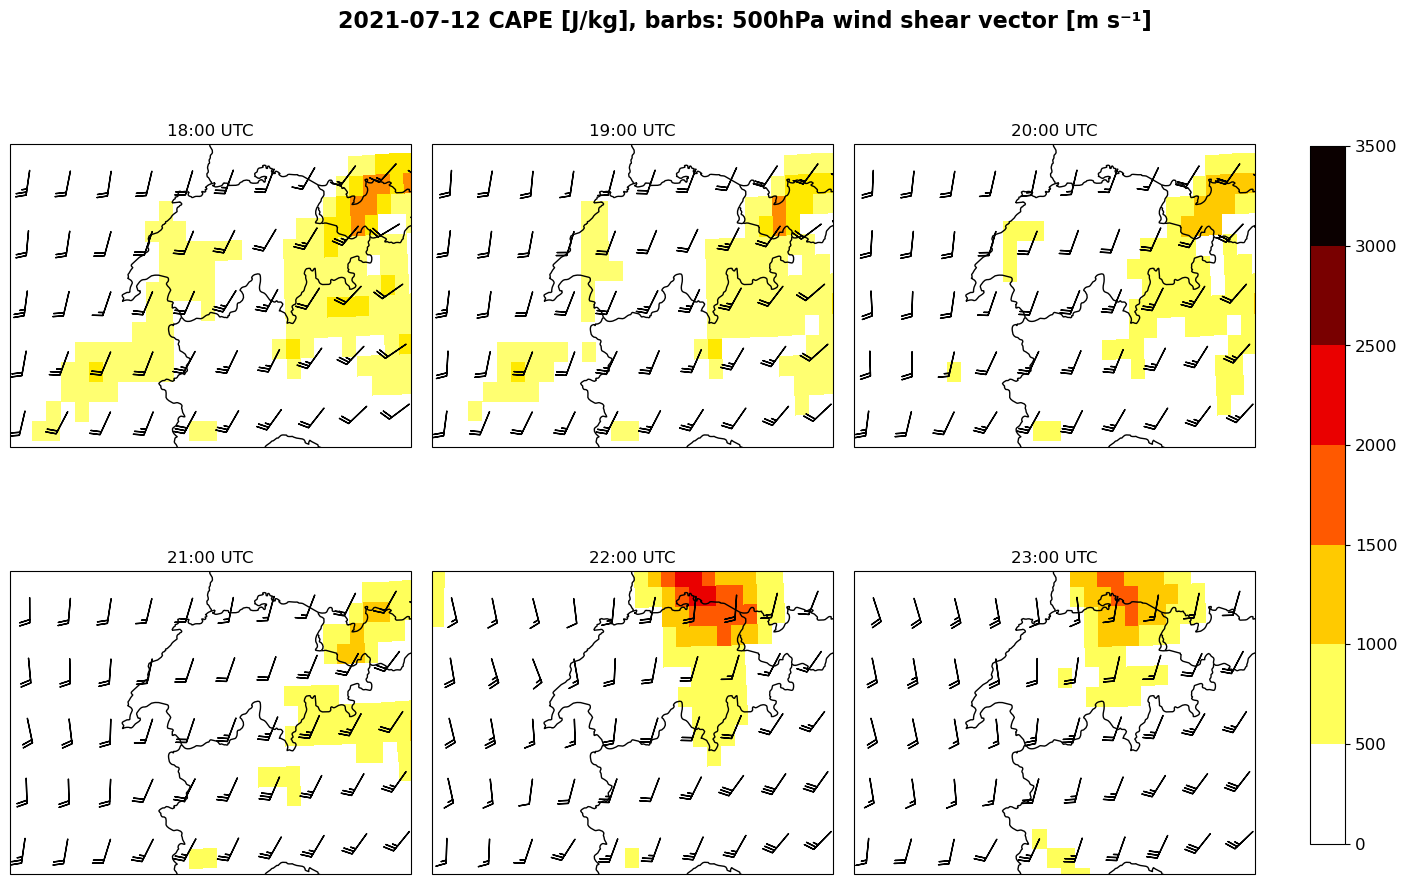

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np

# Set up the projection
projection = ccrs.LambertConformal(central_longitude=6, central_latitude=46)

# Define the spatial extent
extent = [4, 11, 44.3, 48]

# Define time range
time_range = pd.date_range('2021-07-12T18:00:00.000000000', '2021-07-12T23:00:00.000000000', freq='H')

# Initialize subplots with 2x3 layout
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': projection}, figsize=(15, 10))
axes = axes.flatten()  # Flatten axes for easy iteration

# Define custom colormap for CAPE
cape_cmap = plt.get_cmap('hot').reversed()  # Reverse 'hot' to go from white to red

for i, time in enumerate(time_range):
    ax = axes[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # Apply spatial extent to zoom in on region

    # Plot CAPE as filled contours
    cape = df.cape.sel(valid_time=time, longitude=slice(-25, 30), latitude=slice(65, 34))
    cape_plot = cape.plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cape_cmap, add_colorbar=False, vmin=0, vmax=5000, levels=cape_levels
    )
    
    # Plot wind shear vectors as barbs, sub-sampled for reduced density
    u_shear = de.u_shear_500_10.sel(valid_time=time, longitude=slice(-25, 30), latitude=slice(65, 34))
    v_shear = de.v_shear_500_10.sel(valid_time=time, longitude=slice(-25, 30), latitude=slice(65, 34))
    
    # Subsample data for fewer barbs
    stride = 3  # Change this value to adjust density of barbs
    ax.barbs(
        u_shear.longitude.values[::stride], u_shear.latitude.values[::stride],
        u_shear.values[::stride, ::stride], v_shear.values[::stride, ::stride],
        transform=ccrs.PlateCarree(), length=6
    )

    # Set title for each subplot
    ax.set_title(f'{time.strftime("%H:%M UTC")}')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

# Add a single colorbar on the right side
cbar = fig.colorbar(cape_plot, ax=axes, orientation='vertical', fraction=0.03, pad=0.05)
#cbar.set_label('CAPE (J/kg)')
cbar.ax.tick_params(labelsize=12)

# Set main title for the figure
fig.suptitle('2021-07-12 CAPE [J/kg], barbs: 500hPa wind shear vector [m s⁻¹]', fontsize=16, fontweight='bold')

# Adjust layout to make space for the colorbar and reduce white space between rows
#plt.subplots_adjust(left=0.05, right=0.85, top=0.7, bottom=0.1, hspace=0.1, wspace=0.1)
plt.tight_layout(rect=[0, 0, 0.85, 1])

#plt.savefig("/users/fackerma/newproject1/figures/fourth_case/" + '210712_CAPE_500windshear_1.png', dpi=300)





## Synoptic situation

In [2]:
# 500hPa relative humidity & geopotential height

# Set up the projection
projection = ccrs.LambertConformal(central_longitude=6, central_latitude=46)

# Define the spatial extent
extent = [-18, 23.7, 34, 60]

# Define time range, starting from 2019-06-14 06:00 and ending at 2019-06-15 15:00 every 3 hours
time_range = pd.date_range('2021-07-11T12:00:00.000000000', '2021-07-12T21:00:00.000000000', freq='3H')
r_norm = BoundaryNorm(boundaries=r_levels, ncolors=256, clip=True)

# Initialize subplots with 4x3 layout for 12 plots
fig, axes = plt.subplots(4, 3, subplot_kw={'projection': projection}, figsize=(18, 16))
axes = axes.flatten()  # Flatten axes for easy iteration

# Cap the relative humidity data at 100
de['r'] = de['r'].where(de['r'] <= 100, 99)
de['r'] = de['r'].where(de['r'] >= 0, 0.001)  # Cap values below 0 to a minimal positive value

# Define colormap for relative humidity
humidity_cmap = plt.get_cmap('Blues')  # Blue colormap for relative humidity

for i, time in enumerate(time_range):
    ax = axes[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # Apply spatial extent to zoom in on region

    # Plot relative humidity as filled contours
    rh = de.r.sel(valid_time=time, pressure_level=500, longitude=slice(-30, 33), latitude=slice(65, 30))
    rh_plot = rh.plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), cmap=humidity_cmap, add_colorbar=False, vmin=0, vmax=100, levels=r_levels
    )

    # Plot geopotential height as contours
    z_m = de.z_m.sel(valid_time=time, pressure_level=500, longitude=slice(-30, 33), latitude=slice(65, 30))
    z_m_contour = ax.contour(
        z_m.longitude, z_m.latitude, z_m, levels=np.arange(5000, 6000, 50),
        colors='black', transform=ccrs.PlateCarree()
    )
    # Apply white outline to contour labels
    clabels = ax.clabel(z_m_contour, fmt='%d', colors='black', fontsize=6)
    for label in clabels:
        label.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

    # Set title for each subplot
    ax.set_title(f'{time.strftime("%Y-%m-%d %H:%M UTC")}')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

# Add a single colorbar on the right side for relative humidity
cbar = fig.colorbar(rh_plot, ax=axes, orientation='vertical', fraction=0.03, pad=0.05, norm=r_norm, boundaries=r_levels, ticks=r_levels)
cbar.ax.tick_params(labelsize=12)

# Set main title for the figure
fig.suptitle('500hPa Relative Humidity (colors), Geopotential Height [m] (contours)', fontsize=16, fontweight='bold')

# Adjust layout to make space for the colorbar and reduce white space between rows
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

# Save the figure if needed
plt.savefig("/users/fackerma/newproject1/figures/fourth_case/500_r_z_1.png", dpi=300)

# plt.show()


NameError: name 'ccrs' is not defined

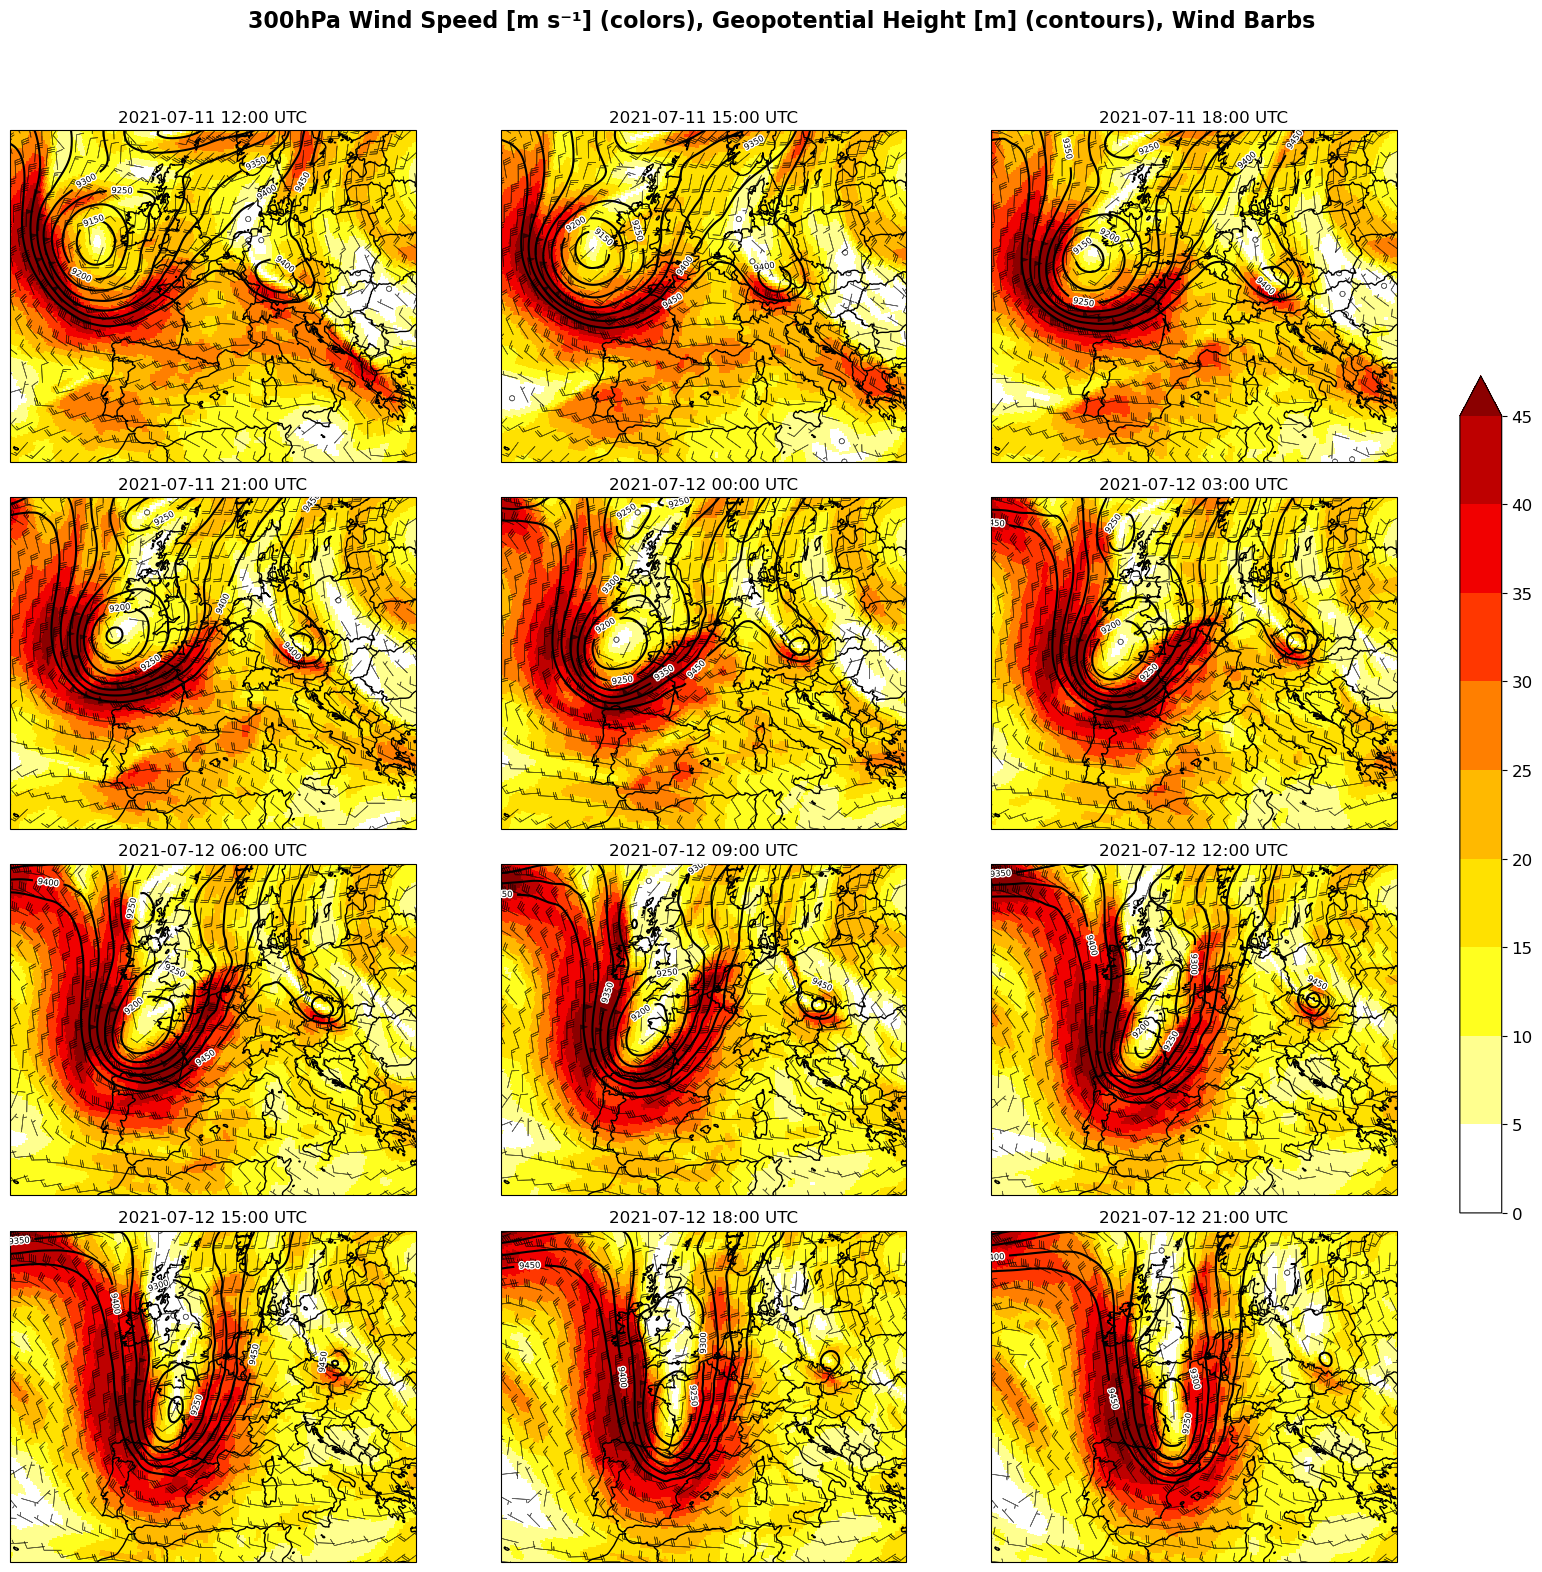

In [ ]:
# 300hPa wind & geopotential height

# Set up the projection
projection = ccrs.LambertConformal(central_longitude=6, central_latitude=46)

# Define the spatial extent
extent = [-18, 23.7, 34, 60]

# Define time range, starting from 2019-06-14 06:00 and ending at 2019-06-15 15:00 every 3 hours
time_range = pd.date_range('2021-07-11T12:00:00.000000000', '2021-07-12T21:00:00.000000000', freq='3H')
wind_speed_norm = BoundaryNorm(boundaries=wind_speed_levels, ncolors=256, clip=True)

# Initialize subplots with 4x3 layout for 12 plots
fig, axes = plt.subplots(4, 3, subplot_kw={'projection': projection}, figsize=(18, 16))
axes = axes.flatten()  # Flatten axes for easy iteration

# Define a custom colormap: white to green to blue
custom_cmap = LinearSegmentedColormap.from_list("colors", ["white","yellow", "orange", "red","darkred"])

# Use this colormap for wind speed
wind_speed_cmap = custom_cmap

for i, time in enumerate(time_range):
    ax = axes[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # Apply spatial extent to zoom in on region

    # Plot 300hPa wind speed as filled contours
    wind_speed = de.wind_speed.sel(valid_time=time, pressure_level=300, longitude=slice(-30, 33), latitude=slice(65, 30))
    wind_speed_plot = wind_speed.plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), cmap=wind_speed_cmap, add_colorbar=False, vmin=0, vmax=100, levels=wind_speed_levels
    )

    # Plot 300hPa geopotential height as contours
    z_m_300 = de.z_m.sel(valid_time=time, pressure_level=300, longitude=slice(-30, 33), latitude=slice(65, 30))
    z_m_contour = ax.contour(
        z_m_300.longitude, z_m_300.latitude, z_m_300, levels=np.arange(8000, 9500, 50),
        colors='black', transform=ccrs.PlateCarree()
    )
    # Apply white outline to contour labels
    clabels = ax.clabel(z_m_contour, fmt='%d', colors='black', fontsize=6)
    for label in clabels:
        label.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

    # Plot wind barbs for 300hPa level
    u = de.u.sel(valid_time=time, pressure_level=300, longitude=slice(-30, 33), latitude=slice(65, 30))
    v = de.v.sel(valid_time=time, pressure_level=300, longitude=slice(-30, 33), latitude=slice(65, 30))
    # Use slicing to reduce the density, e.g., every 3rd point
    ax.barbs(
        u.longitude.values[::7], u.latitude.values[::7], u.values[::7, ::7], v.values[::7, ::7],
        transform=ccrs.PlateCarree(), length=5, color='black', linewidth=0.5, alpha=0.6
    )

    # Set title for each subplot
    ax.set_title(f'{time.strftime("%Y-%m-%d %H:%M UTC")}')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

# Add a single colorbar on the right side for wind speed
cbar = fig.colorbar(wind_speed_plot, ax=axes, orientation='vertical', fraction=0.03, pad=0.05, norm=wind_speed_norm, boundaries=wind_speed_levels, ticks=wind_speed_levels)
cbar.ax.tick_params(labelsize=12)

# Set main title for the figure
fig.suptitle('300hPa Wind Speed [m s⁻¹] (colors), Geopotential Height [m] (contours), Wind Barbs', fontsize=16, fontweight='bold')

# Adjust layout to make space for the colorbar and reduce white space between rows
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

# Save the figure if needed
#plt.savefig("/users/fackerma/newproject1/figures/fourth_case/300_wind_speed_z_m_1.png", dpi=300)

# plt.show()


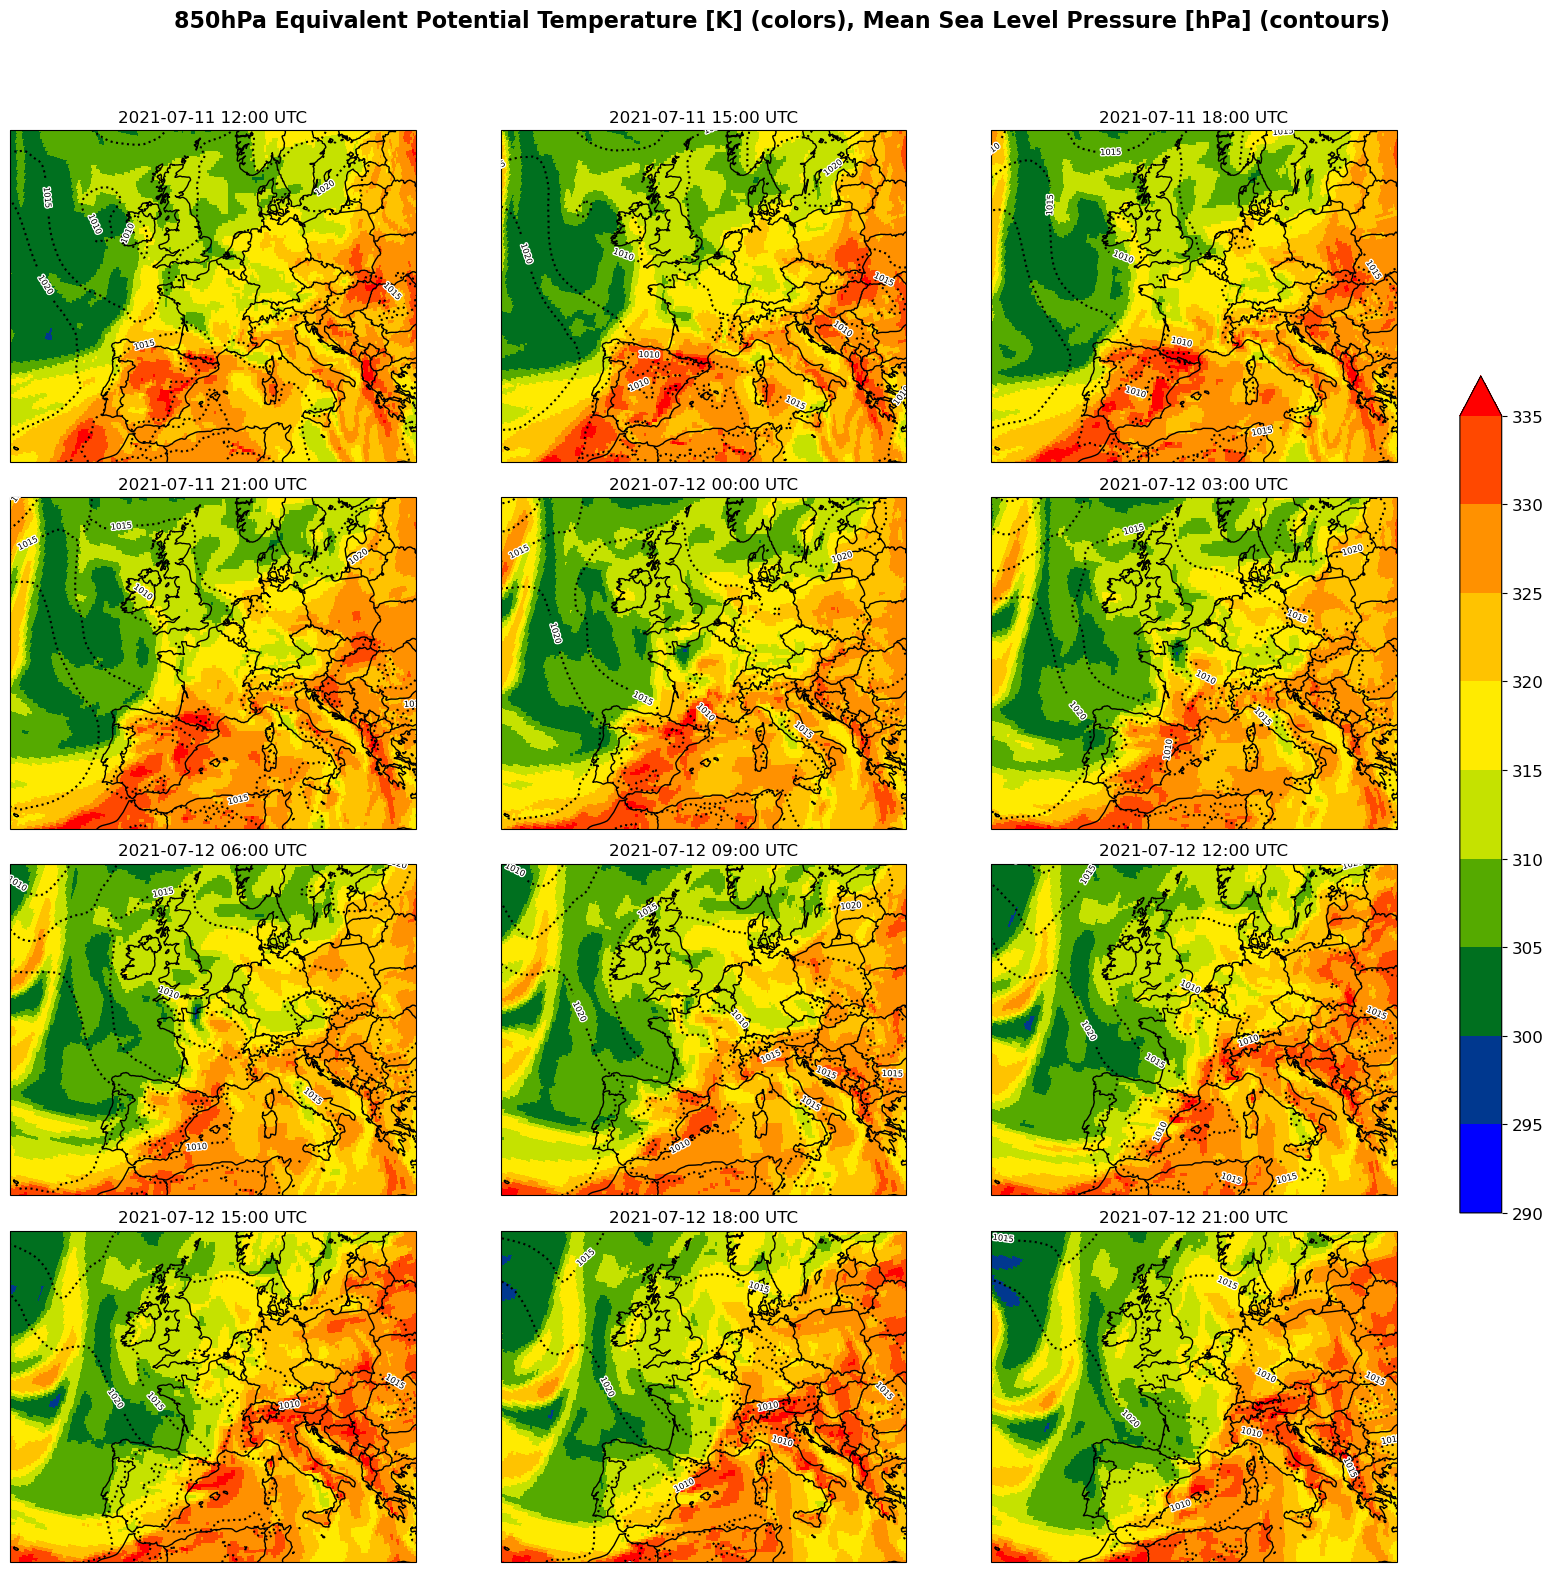

In [ ]:
# 850hPa theta e & mslp

# Set up the projection
projection = ccrs.LambertConformal(central_longitude=6, central_latitude=46)

# Define the spatial extent
extent = [-18, 23.7, 34, 60]

# Define time range, starting from 2019-06-14 06:00 and ending at 2019-06-15 15:00 every 3 hours
time_range = pd.date_range('2021-07-11T12:00:00.000000000', '2021-07-12T21:00:00.000000000', freq='3H')
r_norm = BoundaryNorm(boundaries=r_levels, ncolors=256, clip=True)

# Initialize subplots with 4x3 layout for 12 plots
fig, axes = plt.subplots(4, 3, subplot_kw={'projection': projection}, figsize=(18, 16))
axes = axes.flatten()  # Flatten axes for easy iteration

# Cap the relative humidity data at 100
#de['r'] = de['r'].where(de['r'] <= 100, 99)
#de['r'] = de['r'].where(de['r'] >= 0, 0.001)  # Cap values below 0 to a minimal positive value

# Define colormap for relative humidity
theta_e_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "green", "yellow", "orange", "red"], N=256) # Blue colormap for relative humidity

for i, time in enumerate(time_range):
    ax = axes[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # Apply spatial extent to zoom in on region

    # Plot theta_e as filled contours
    te = dh.theta_e.sel(valid_time=time, pressure_level=850, longitude=slice(-30, 33), latitude=slice(65, 30))
    te_plot = te.plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(), cmap=theta_e_cmap, add_colorbar=False, vmin=290, vmax=340, 
        levels=theta_e_levels
    )

    # Plot mslp as contours
    mslp = dg.mslp_hpa.sel(valid_time=time, #pressure_level=500, 
                          longitude=slice(-30, 33), latitude=slice(65, 30))
    mslp_contour = ax.contour(mslp.longitude, mslp.latitude, mslp, levels=mslp_levels,
        colors='black', linestyles='dotted', transform=ccrs.PlateCarree())

    # Apply white outline to contour labels
    clabels = ax.clabel(mslp_contour, fmt='%d', colors='black', fontsize=6)
    for label in clabels:
        label.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

    # Set title for each subplot
    ax.set_title(f'{time.strftime("%Y-%m-%d %H:%M UTC")}')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

# Add a single colorbar on the right side for relative humidity
cbar = fig.colorbar(te_plot, ax=axes, orientation='vertical', fraction=0.03, pad=0.05 #, norm=r_norm, boundaries=r_levels, ticks=r_levels
                    )
cbar.ax.tick_params(labelsize=12)

# Set main title for the figure
fig.suptitle('850hPa Equivalent Potential Temperature [K] (colors), Mean Sea Level Pressure [hPa] (contours)', fontsize=16, fontweight='bold')

# Adjust layout to make space for the colorbar and reduce white space between rows
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

# Save the figure if needed
#plt.savefig("/users/fackerma/newproject1/figures/fourth_case/850_theta_e_mslp_1.png", dpi=300)

# plt.show()


## Station data

In [4]:
# Data import, assimilation
file_path = '/scratch/mch/fackerma/orders/case_120721/stations/20210712.csv'

# Open the file and read its contents
with open(file_path, 'r') as file:
    station_data = file.readlines()  # Read all lines into a list

# Import stations readme
file_path = '/users/fackerma/newproject1/stations_readme.csv'

# Open and read the file as plain text
try:
    with open(file_path, 'r') as stations:
        stations = stations.readlines()  # Read all lines into a list
    #for line in content[:10]:  # Print the first 10 lines for inspection
        #print(line.strip())
except Exception as e:
    print(f"Error reading file: {e}")

# Parse the station metadata to create a dictionary mapping station ID to coordinates and altitude
station_info = {}

# Extract the relevant station data from 'stations' (first 158 rows)
for line in stations[0:0+158]:  # Starts from line 5, inclusive
    parts = line.strip().split("\t")
    station_id = parts[0].strip()  # First column: Station ID
    
    # Extract coordinates (last column)
    coordinates = parts[-1].strip()  
    x, y = map(int, coordinates.split("/"))  # Split the coordinates into x and y

    # Extract altitude (using regex to find the number before "m a.s.l.")
    altitude_match = re.search(r'(\d+)\s*m\s*a\.s\.l\.', parts[1])
    altitude = int(altitude_match.group(1)) if altitude_match else None  # Default to None if no altitude found
    
    station_info[station_id] = (x, y, altitude)

# Add Swiss coordinates and altitude to 'station_data'
updated_station_data = []

# Add headers for clarity
header = station_data[0].strip() + "   X_COORD   Y_COORD   ALTITUDE\n"
updated_station_data.append(header)

for line in station_data[1:]:  # Skip the header
    parts = line.strip().split()
    station_id = parts[0].strip()  # First column: Station ID
    
    # Lookup coordinates and altitude for the station
    x, y, altitude = station_info.get(station_id, (None, None, None))
    
    if x is not None and y is not None and altitude is not None:
        # Append the coordinates and altitude as new columns
        updated_line = line.strip() + f"   {x}   {y}   {altitude}\n"
    else:
        # In case no coordinates or altitude are found (unlikely here), keep it unchanged
        updated_line = line.strip() + "   N/A   N/A   N/A\n"
    
    updated_station_data.append(updated_line)

# Assuming converter.LV03toWGS84() function is defined, and it converts LV03 to WGS84
# Function to convert LV03 to WGS84 (assuming this is already defined)
# Example: converter.LV03toWGS84(x, y, altitude) returns [latitude, longitude, altitude]

# Iterate over each row in updated_station_data (skip the header)
for i, line in enumerate(updated_station_data[1:], start=1):
    parts = line.strip().split()
    
    # Extract the X_COORD, Y_COORD, and ALTITUDE for the current station
    x_coord = int(parts[-3])  # X_COORD is the second last column
    y_coord = int(parts[-2])  # Y_COORD is the last column before altitude
    altitude = int(parts[-1])  # ALTITUDE is the last column in the row
    
    # Convert LV03 (x_coord, y_coord, altitude) to WGS84 (latitude, longitude, altitude)
    wgs84 = converter.LV03toWGS84(x_coord, y_coord, altitude)
    
    # Append the WGS84 values as new columns: latitude, longitude, altitude
    updated_station_data[i] = line.strip() + f"   {wgs84[0]}   {wgs84[1]}   {wgs84[2]}"
    
# Add headers for latitude, longitude, and altitude to the header row
header = updated_station_data[0].strip() + "   LATITUDE   LONGITUDE   ALTITUDE_NEW"
updated_station_data[0] = header

# Data assimilation
# Extract the headers and rows
headers = updated_station_data[0].split()
data = [line.split() for line in updated_station_data[1:]]

# Create a DataFrame
df = pd.DataFrame(data, columns=headers)

# Convert relevant columns to numeric (e.g., the wind gust column '101')
df['101'] = pd.to_numeric(df['101'], errors='coerce')

# Find the row with the max wind gust for each station
max_gusts = df.loc[df.groupby('STA')['101'].idxmax()]

# Create a new DataFrame with the rows of interest
new_df = max_gusts[['STA', 'JAHR', 'MO', 'TG', 'HH', 'MM', '101', '197', 'LATITUDE', 'LONGITUDE', 'ALTITUDE']]

# Sort the new dataframe by the '101' column in descending order
new_df_sorted = new_df.sort_values(by='101', ascending=False)

# Filter out rows where the '101' value is greater than 200
new_df_filtered = new_df_sorted[new_df_sorted['101'] <= 300]


In [6]:
new_df_filtered

STA  JAHR MO  TG  HH  MM   101  197            LATITUDE  \
13948  854  2021  7  12  20  40  37.6  322   47.17943029837612   
15394  866  2021  7  12  21  40  33.3  162    45.9836372007407   
6888    60  2021  7  12  20   0  32.7  140   46.65243510758286   
7750   273  2021  7  12  19  40  27.9  181  46.770604778354375   
17552  521  2021  7  12  21  20  27.1  160   46.39151893857831   
...    ...   ... ..  ..  ..  ..   ...  ...                 ...   
11633   32  2021  7  12  18  50   6.1    1  46.811575755495866   
4883    82  2021  7  12  21  50   6.0  281   47.47989208341554   
20147   50  2021  7  12  21  50   5.4   55  46.160034284369935   
20008   22  2021  7  12  22  40   4.9  346  46.255080586503276   
20995   47  2021  7  12  19  10   4.8  199  46.004225802837276   

                LONGITUDE ALTITUDE  
13948   8.004755316485923      522  
15394   7.785750662266701     3129  
6888    8.615046317179816     2286  
7750    8.425977688284725     3045  
17552   7.098251775488976     1412  
...                   ...      ...  
11633  6.9424722976549225      490  
4883     8.90491127045904      539  
20147   8.933671619698977      203  
20008   9.163750055743852      324  
20995   8.960320421864175      273  

[150 rows x 11 columns]

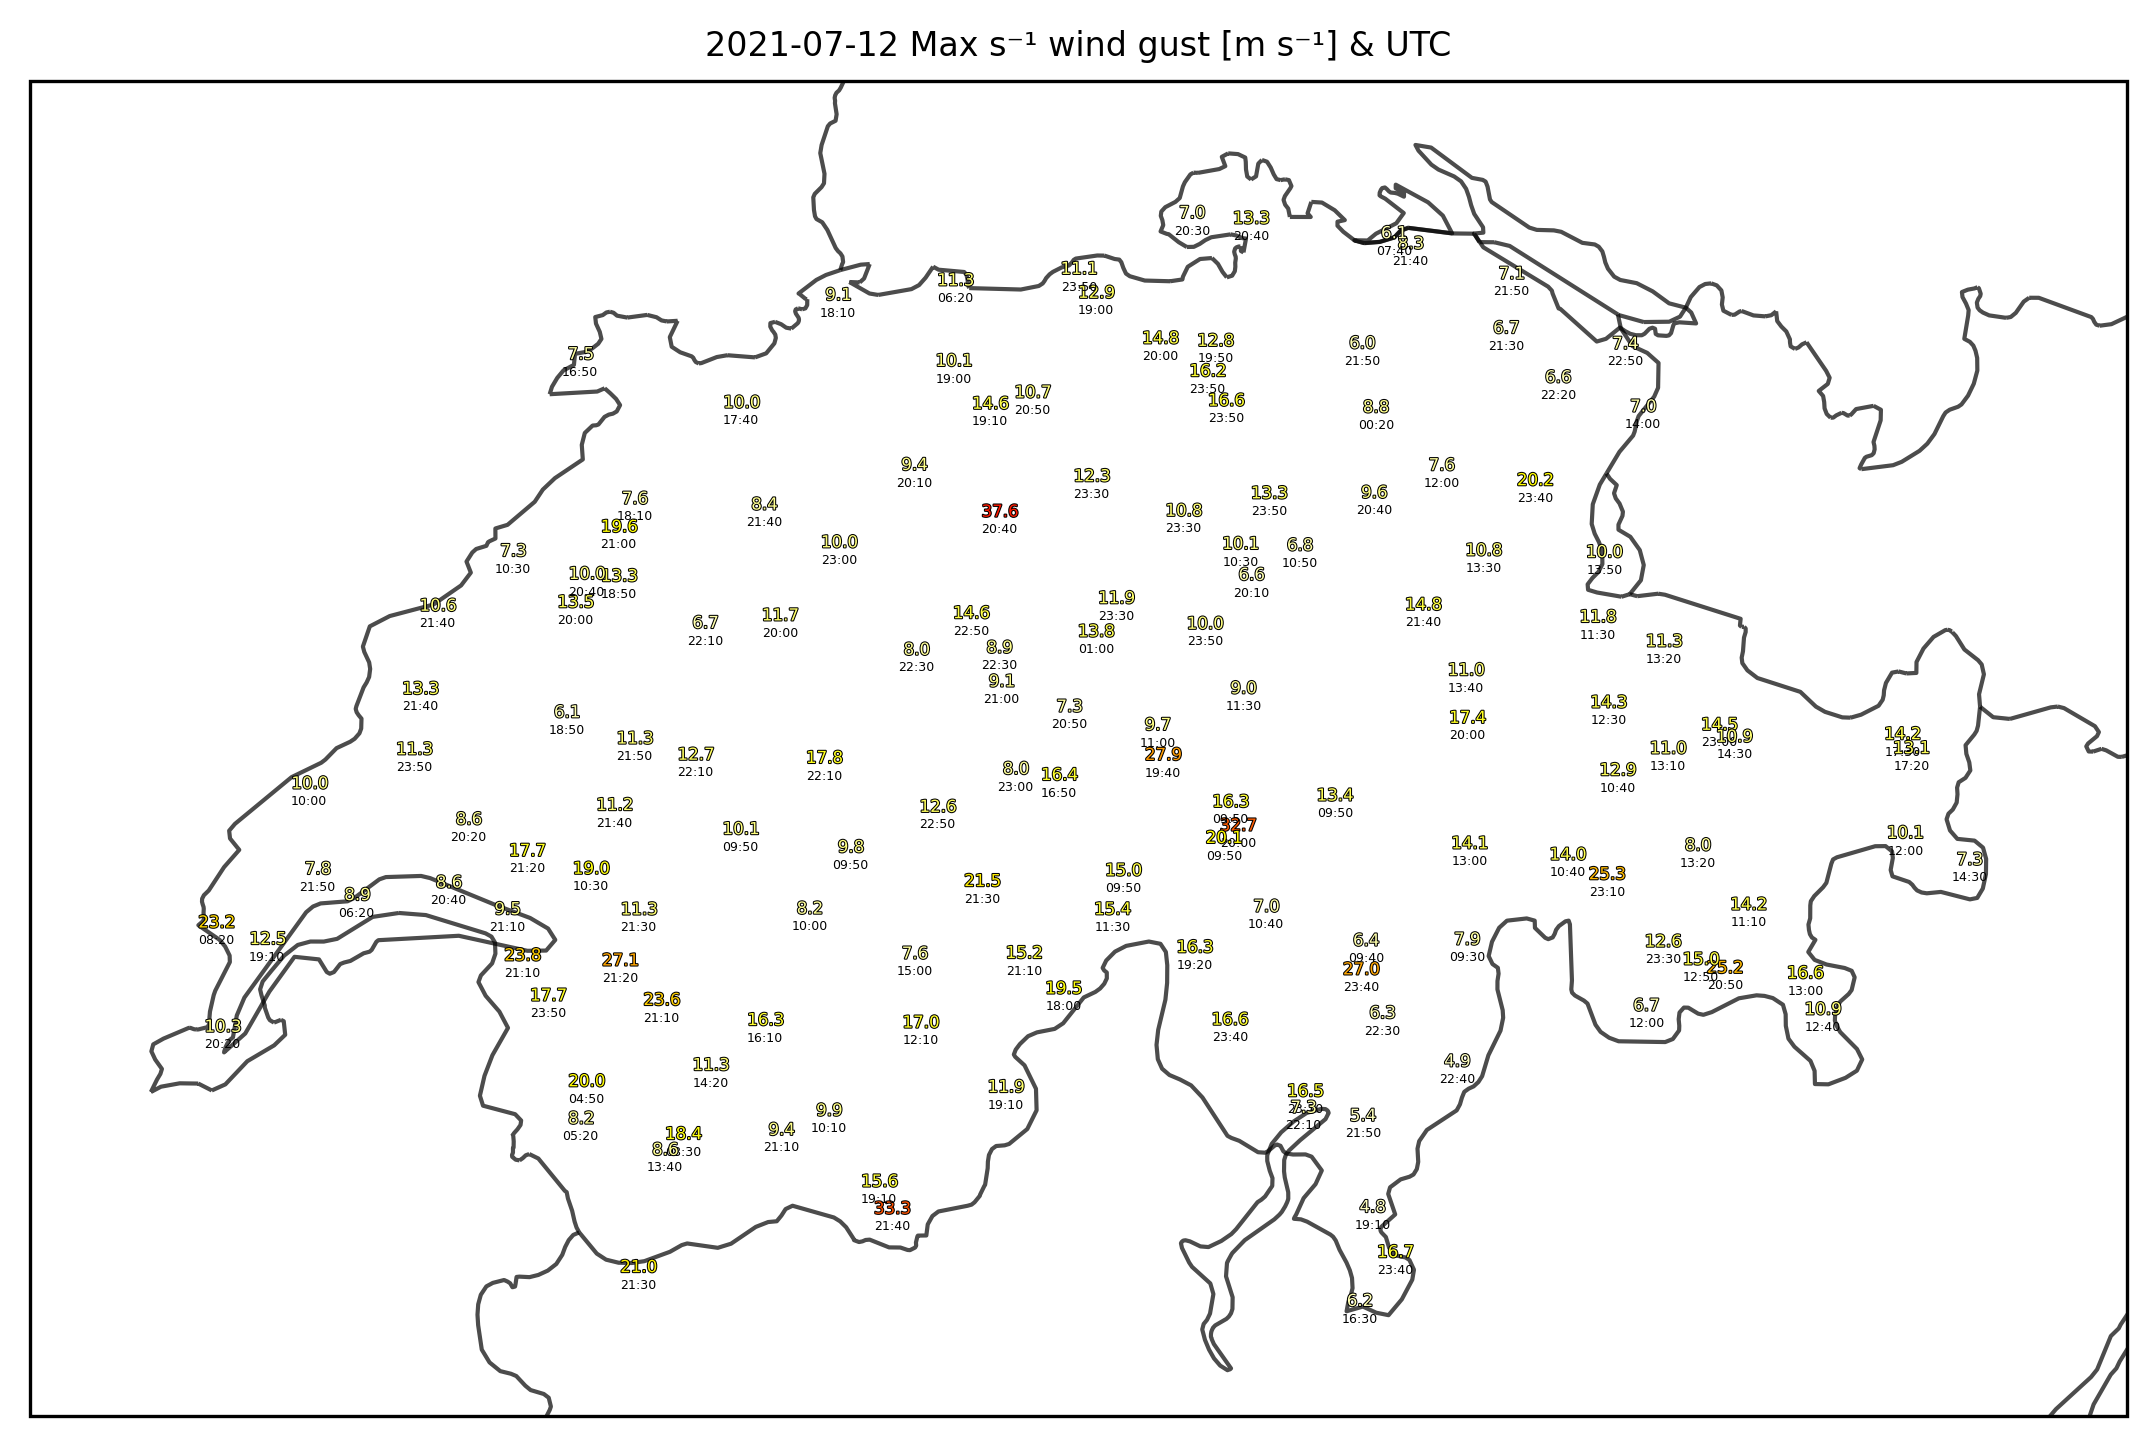

In [ ]:
# Max per second wind gust

# Assuming your filtered dataframe is already ready
# Extract relevant columns
station_ids = new_df_filtered['STA'].values
# Convert the latitude and longitude to float explicitly if not already
station_lats = new_df_filtered['LATITUDE'].astype(float).values
station_lons = new_df_filtered['LONGITUDE'].astype(float).values

# Convert to float explicitly
wind_gusts = new_df_filtered['101'].astype(float).values
wind_directions = new_df_filtered['197'].astype(float).values

# Assuming 'new_df_filtered' is your DataFrame
# Extract hours and minutes columns and combine them into a single array in HH:MM format
time_array = new_df_filtered['HH'].astype(str).str.zfill(2) + ':' + new_df_filtered['MM'].astype(str).str.zfill(2)

# Convert to a NumPy array if needed
time_array = time_array.to_numpy()


# Set the projection
projection = ccrs.epsg(3035)

# Create figure with one subplot (dBZC composite)
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': projection}, dpi=300)

# Set background to white for the plot
fig.patch.set_facecolor('white')  # Set the overall figure background
ax.set_facecolor('white')  # Set axis background

# Add Radar, Geneva, and Lausanne locations to the plot
ax.set_extent([5.7, 10.8, 45.65, 47.85], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.7)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.7)

# Normalize the wind gust values to a range [0, 1] for the colormap
norm = mcolors.Normalize(vmin=0, vmax=40)

# Define the custom colormap
colors = ['white', 'yellow', 'red']
n_bins = 100  # Number of bins in the colormap
cmap = mcolors.LinearSegmentedColormap.from_list("blue_to_red", colors, N=n_bins)


# Example of the loop
for i in range(len(station_ids)):
    # Get the color based on the wind_gusts value
    color = cmap(norm(wind_gusts[i]))

    # Plot the wind gust value at each station as text with the dynamic color
    ax.text(station_lons[i], station_lats[i], f'{wind_gusts[i]:.1f}', color=color, fontsize=4,
            ha='center', va='center', transform=ccrs.PlateCarree(),
            path_effects=[path_effects.withStroke(linewidth=0.5, foreground='black')])
     # Plot the time value just below the wind gust value
    ax.text(station_lons[i], station_lats[i] - 0.03, time_array[i], color='black', fontsize=3,
            ha='center', va='center', transform=ccrs.PlateCarree() #,
            #path_effects=[path_effects.withStroke(linewidth=0.5, foreground='white')]
            )

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
ax.set_title('2021-07-12 Max s⁻¹ wind gust [m s⁻¹] & UTC', color='black', fontsize=8, x=0.5)

# Save the figure (adjust this line to your desired path)
#plt.savefig("/users/fackerma/newproject1/figures/fourth_case/maxgust_CH.png", facecolor='white', dpi=300)

#plt.show()


## Soundings

In [7]:
file_path = "/scratch/mch/fackerma/orders/case_120721/Soundings/sounding_2021071212.csv"
# Specify the delimiter as a semicolon
soundings_df = pd.read_csv(file_path, delimiter=';')

# Rename specific columns
soundings_df = soundings_df.rename(columns={
    'zreppps0': 'hPa', 
    'zrettts0': 'temp', 
    'zretdes0': 'dewpoint temp'
})

# Replace non-numeric values with NaN
soundings_df['temp'] = pd.to_numeric(soundings_df['temp'], errors='coerce')
soundings_df['dewpoint temp'] = pd.to_numeric(soundings_df['dewpoint temp'], errors='coerce')

# Drop rows where temp or dewpoint temp is NaN
soundings_df = soundings_df.dropna(subset=['temp', 'dewpoint temp'])

# Ensure columns are in the correct units
soundings_df['hPa'] = soundings_df['hPa'].astype(float) * units.hPa
soundings_df['temp'] = soundings_df['temp'].astype(float) * units.degC
soundings_df['dewpoint temp'] = soundings_df['dewpoint temp'].astype(float) * units.degC

# Extract the required variables
pressure = soundings_df['hPa']
temperature = soundings_df['temp']
dewpoint = soundings_df['dewpoint temp']

# Ensure variables have the correct units
p = pressure.values * units.hPa
T = temperature.values * units.degC
Td = dewpoint.values * units.degC

# Check and debug the pressure array
sort_idx = np.argsort(p)[::-1]
p = p[sort_idx]
T = T[sort_idx]
Td = Td[sort_idx]



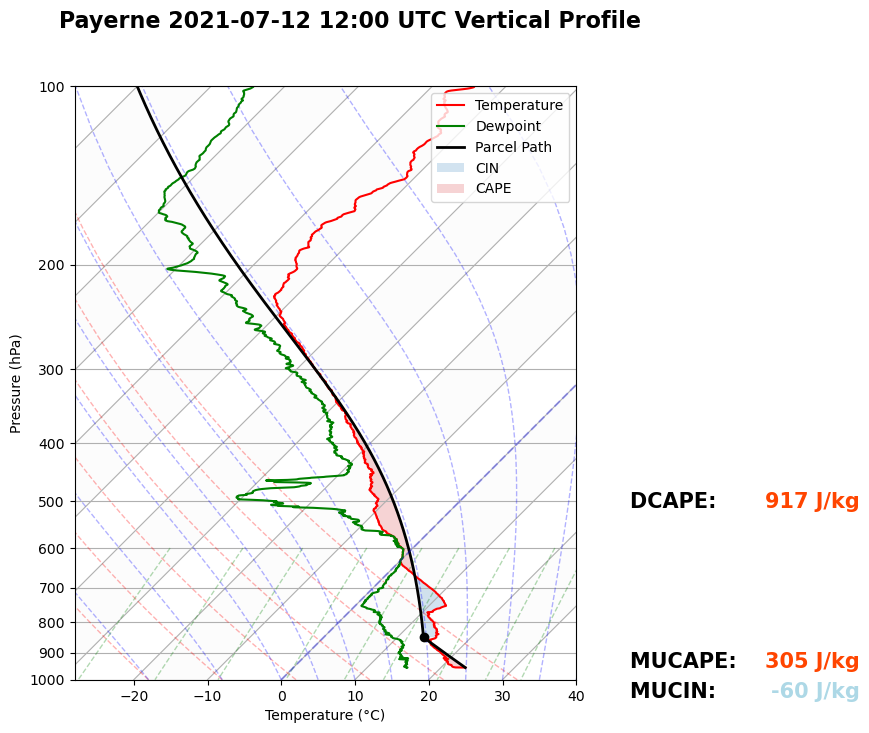

In [ ]:
# Plot Payerne Soundings
fig = plt.figure(figsize=(10, 10))

# Grid for plots
gs = gridspec.GridSpec(3, 3)
skew = SkewT(fig, rotation=45, subplot=gs[:, :2])

# Adjust the rotation parameter to tilt the plot more to the right
#skew = mpplots.SkewT(fig, rotation=45)  # Default is 30, increase for more tilt

# Plot the data
skew.plot(p, T, 'r', label='Temperature')
skew.plot(p, Td, 'g', label='Dewpoint')

lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='Parcel Path')

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td, 
               alpha=0.2, label='CIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='CAPE')

# Add labels, grid, and atmospheric lines
skew.ax.set_xlim(-28, 40)  # Adjust as needed
skew.ax.set_ylim(1000, 100)  # Pressure range
skew.ax.set_xlabel('Temperature (°C)')
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.grid(True)


# Set the facecolor of the skew-t object and the figure to white
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Here we can use some basic math and Python functionality to make a cool
# shaded isotherm pattern.
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(0, 8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# Add dry adiabats, moist adiabats, and mixing ratio lines
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)



# Here are some classic severe parameters!
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
dcape = mpcalc.downdraft_cape(p, T, Td)



# mixed layer parcel properties!
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, prof, depth=50 * units.hPa)

# most unstable parcel properties!
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

# Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

# Compute Surface-based CAPE
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)

dcape_value = dcape[0]

# Plot DCAPE on the figure
plt.figtext(0.68, 0.37, 'DCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.91, 0.37, f'{dcape_value:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
#plt.figtext(0.68, 0.21, 'SBCAPE: ', weight='bold',
            #fontsize=15, color='black', ha='left')
#plt.figtext(0.91, 0.21, f'{sbcape:.0f~P}', weight='bold',
            #fontsize=15, color='orangered', ha='right')
#plt.figtext(0.68, 0.18, 'SBCIN: ', weight='bold',
            #fontsize=15, color='black', ha='left')
#plt.figtext(0.91, 0.18, f'{sbcin:.0f~P}', weight='bold',
            #fontsize=15, color='lightblue', ha='right')
#plt.figtext(0.68, 0.29, 'MLCAPE: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.91, 0.29, f'{mlcape:.0f~P}', weight='bold',
            #fontsize=15, color='orangered', ha='right')
#plt.figtext(0.68, 0.26, 'MLCIN: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.91, 0.26, f'{mlcin:.0f~P}', weight='bold',
            #fontsize=15, color='lightblue', ha='right')
plt.figtext(0.68, 0.21, 'MUCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.91, 0.21, f'{mucape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.68, 0.18, 'MUCIN: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.91, 0.18, f'{mucin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')


# Add legends to the skew and hodo
skewleg = skew.ax.legend(loc='upper left')
#hodoleg = h.ax.legend(loc='upper left')

# add a quick plot title, this could be automated by
# declaring a station and datetime variable when using
# realtime observation data from Siphon.
plt.figtext(0.4, 0.85, 'Payerne 2021-07-12 12:00 UTC Vertical Profile',
            weight='bold', fontsize=16, ha='center')

plt.legend(loc='upper right')

#plt.savefig('/users/fackerma/newproject1/figures/fourth_case/Payerne_21071212_1.png', dpi=300)